In [1]:
from desaggregation import *
from value_based_solver import *
from solver_reporter import *
from sklearn import metrics

# Data

In [ ]:
data_dir = './dane'

In [2]:
data = pd.read_csv(f'{data_dir}/selected_data.csv').set_index('Year')
mod_name = '' 
# data

In [3]:
cri_forecast = pd.read_csv(f'{data_dir}/pl_forecast.csv').set_index('Year')
#cri_forecast

In [4]:
levels_ranges = pd.read_csv(f'{data_dir}/levels_ranges.csv').set_index('idx')
is_gain = levels_ranges.loc['is_gain'][1:]
cost_criteria = np.where(is_gain < 1.0)[0]

levels_ranges = 0.01 * levels_ranges # as percents

In [5]:
def split_data(all_data):
    __demand_data = all_data['Electricity demand']
    __criteria_data = all_data.drop('Electricity demand', axis=1)
    return __criteria_data, __demand_data

cri_data, dem_data = split_data(data)
cri_bnd, dem_bnd = split_data(levels_ranges.iloc[:-1])

# Parameters

## some useful functions

In [6]:
_alpha = 5
_gamma = 0.01

dem_name = 'Zapotrzebowanie el.'
cri_names = [
"PKB",
"PKB UE",
"Bezrobocie",
"Populacja",
"HDD",
#"CDD",
"ODEX",
"Cena węgla kamienego",
"Cena węgla brunatnego",
"Cena energii"]

In [7]:
def usual_valbas(criteria_data, demand_data, split_year):
    global _alpha
    global _gamma
    global cost_criteria

    valbas = Desaggregation(criteria_data, demand_data, split_year)
    valbas.alpha  =  _alpha
    valbas.alpha_i = _alpha
    valbas.gamma  =  _gamma
    valbas.gamma_i = _gamma
    valbas.cost_criteria = cost_criteria
    valbas.epsilon = 0.005
    
    global cri_bnd, dem_bnd
    valbas.set_levels(cri_bnd, dem_bnd)

    return valbas

In [8]:
def value_function_formula(solver):
    print('Y = ', end='')
    for i in range(len(solver.b)):
        b = solver.b[i]
        print("{:0.2f}".format(b), end='')
        print(f" X_{i+1} + ", end='')

In [9]:
def get_prediction_errors(y_test, y_pred):
    errs = {}
    errs['mae'] = np.round(metrics.mean_absolute_error(y_test, y_pred), 3)
    errs['mape'] = np.round(metrics.mean_absolute_percentage_error(y_test, y_pred), 3)
    errs['rmse'] = np.round(metrics.mean_squared_error(y_test, y_pred, squared=False), 3)
#    errs['r2'] = np.round(metrics.r2_score(y_test, y_pred), 3)
    return errs

In [10]:
def get_marginal_value_functions(xs):
    mar_val_fcs =[]
    for i in range(solver._m.num_cri):
        mar_val_fcs.append([xs[i, k] for k in range(solver._m.alpha_i)])
    return mar_val_fcs

def marginal_X( lvls, mar_val, x ):
    arg = np.where(lvls < x )[0]
    if len(arg)==0 or arg[-1] == len(lvls)-1:
        return mar_val[-1]
    _ar = arg[-1]
    a1 = mar_val[_ar]
    a2 = mar_val[_ar+1]
    a1 = 1 if a1 == 0 else a1
    return a2/a1 * (x - lvls[_ar])

def predict_changes(model, weights):
    n = model.num_cri
    X_pct = model.criteria_test.pct_change().dropna().to_numpy()
    preds = []
    for Xj in X_pct:
        preds.append( np.dot(weights, Xj) )
    return preds

def predict_values(begining, pred_pct):
    y_pred = [begining]
    for i in range(len(pred_pct)):
        y_pred.append(y_pred[-1] * (1 + pred_pct[i]))
    return y_pred[1:]


In [11]:
# cri_data = cri_data.drop(columns=['CDD', 'HDD'])
# cri_forecast = cri_forecast.drop(columns=['CDD', 'HDD'])

# cri_bnd.drop(columns=['CDD', 'HDD'])
# cri_names = cri_names[:3] + cri_names[5:]

# Experiments
## learning on data from 1999 - 2014; test 2015 - 2020

In [12]:
valbas = usual_valbas(cri_data , dem_data, split_year=2015)

In [13]:
solver = ValueBasedSolver(valbas)
solver.solve()

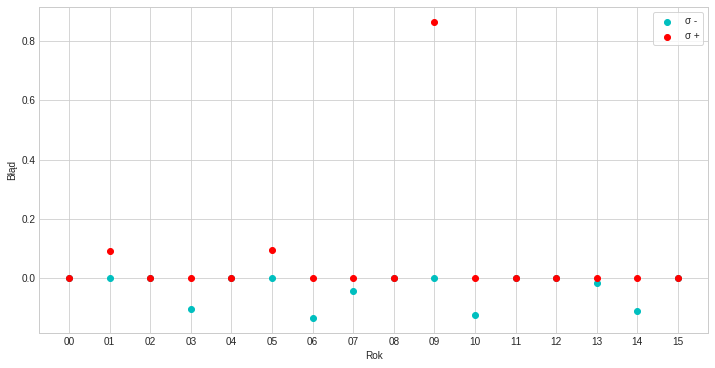

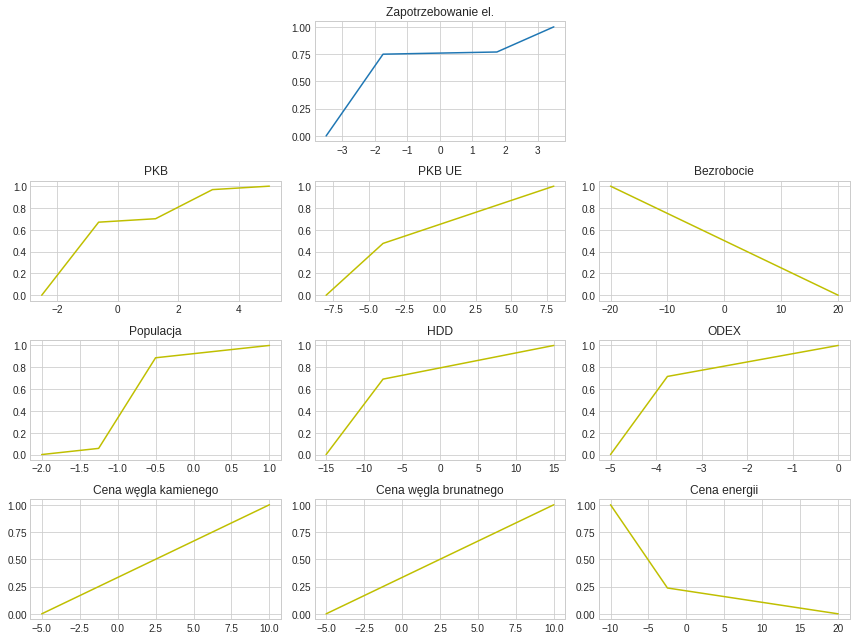

In [14]:
reporter = ValueBasedSolverReporter(solver, dem_name, cri_names, f'train{mod_name}')
reporter.report()

### Post optimization robustness analysis

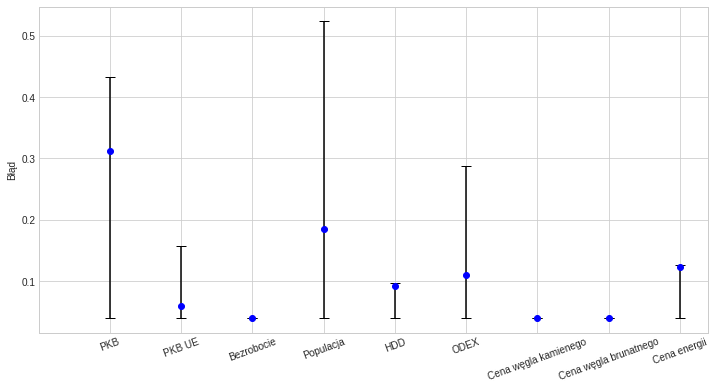

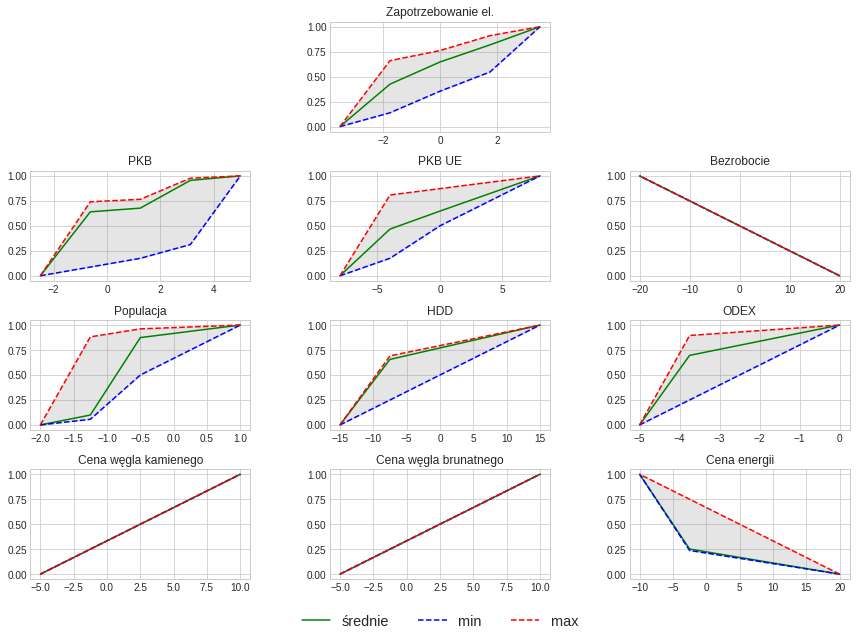

In [15]:
for i in range(valbas.num_cri):
    for K in range(1, valbas.alpha_i):
        solver.solve(postOptimize = ("min", i, K))
        solver.solve(postOptimize = ("max", i, K))

reporter.plot_post_opt()

In [16]:
value_function_formula(solver)
valbas.cost_criteria

Y = 0.32 X_1 + 0.06 X_2 + 0.04 X_3 + 0.18 X_4 + 0.10 X_5 + 0.11 X_6 + 0.04 X_7 + 0.04 X_8 + 0.13 X_9 + 

array([2, 8])

## Prediction on testing set

In [17]:
y_test = valbas.demand_test.iloc[1:]

weights = solver.b
pred_pct = predict_changes(valbas, weights)
y_pred = predict_values(valbas.demand.iloc[-1], pred_pct)

print(pred_pct)
print(y_pred)

#print(pd.DataFrame(np.array([np.trunc(y_pred), list(y_test)])).set_index(y_test.index))

e = get_prediction_errors(y_test, y_pred)
print(f'MAE & ', e['mae'], '\\\\ ')
print(f'MAPE & ', e['mape'], '\\\\ ')
print(f'RMSE & ', e['rmse'], '\\\\ ')

[0.006663525203310471, 0.016973893586839497, 0.01044509339068683, 0.0008509251745222792, 0.007089747391493744]
[162513.74618177203, 165272.23721586008, 166998.52116846747, 167140.6244142377, 168325.6092201912]
MAE &  2791.096 \\ 
MAPE &  0.017 \\ 
RMSE &  2864.138 \\ 


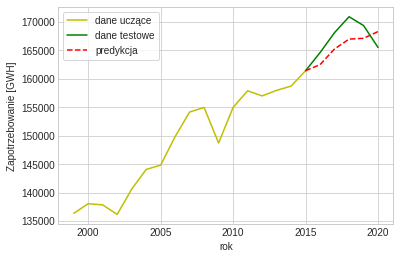

In [18]:
reporter.plot_predictions(y_pred)

MAE & 7365.661 & 2809.21 & 2571.561 \\
MAPE & 0.044 & 0.017 & 0.015 \\
RMSE & 7777.069 & 2882.976 & 3569.789 \\


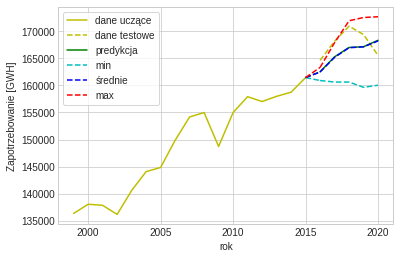

In [19]:
b_min, b_mean, b_max = solver.get_postopt_b()
x_min, x_mean, x_max = solver.get_postopt_x()

pct_min = predict_changes(valbas, b_min)
pct_mean = predict_changes(valbas, b_mean)
pct_max = predict_changes(valbas, b_max)

y_pred_min = predict_values(valbas.demand.iloc[-1], pct_min)
y_pred_mean = predict_values(valbas.demand.iloc[-1], pct_mean)
y_pred_max = predict_values(valbas.demand.iloc[-1], pct_max)

min_e = get_prediction_errors(y_test, y_pred_min)
mean_e = get_prediction_errors(y_test, y_pred_mean)
max_e = get_prediction_errors(y_test, y_pred_max)

for err in ['mae', 'mape', 'rmse']:
    print(err.upper(), '&', min_e[err],'&', mean_e[err],'&', max_e[err], '\\\\')

reporter.plot_predictions_and_postopt(y_pred, y_pred_min, y_pred_mean, y_pred_max)

# Prediction

In [20]:
pred_cri_data = pd.concat([cri_data, cri_forecast]) 
pred_dem_data = dem_data.reindex(pred_cri_data.index)
pred_valbas = usual_valbas(pred_cri_data, pred_dem_data, 2020)

solver = ValueBasedSolver(pred_valbas)
solver.solve()

In [21]:
pred_cri_data.shape

(28, 9)

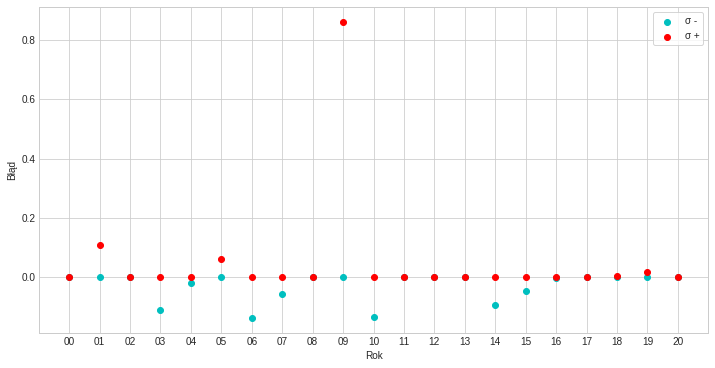

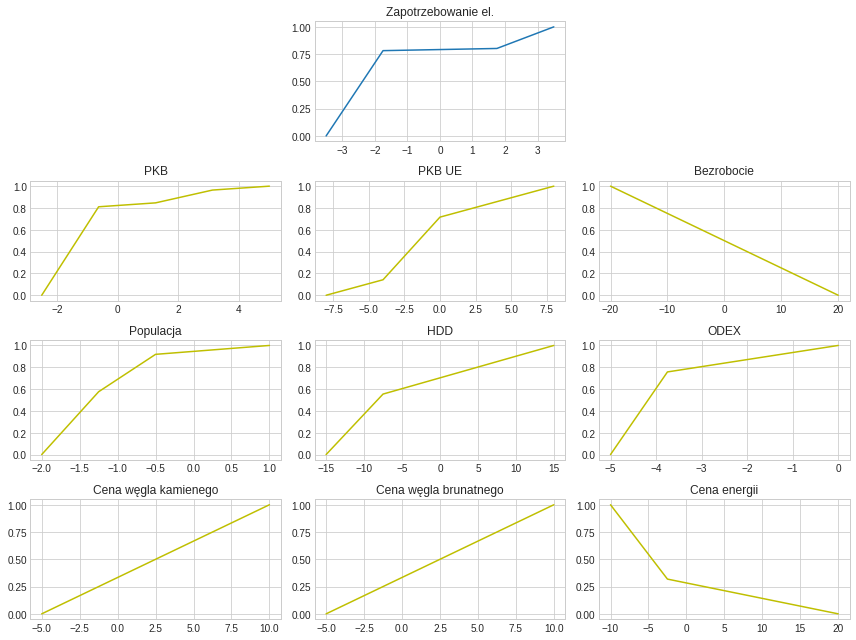

In [22]:
reporter = ValueBasedSolverReporter(solver, dem_name, cri_names, f"predict{mod_name}")
reporter.report()


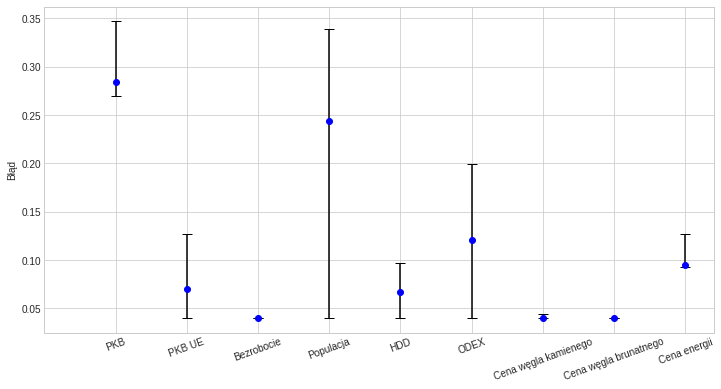

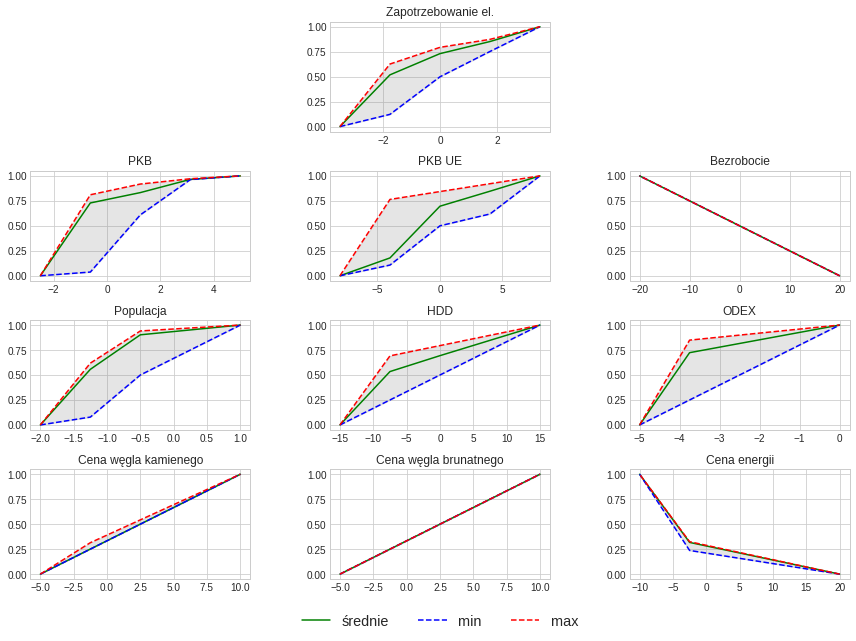

In [23]:
for i in range(valbas.num_cri):
    for K in range(1, valbas.alpha_i):
        solver.solve(postOptimize = ("min", i, K))
        solver.solve(postOptimize = ("max", i, K))

reporter.plot_post_opt()

In [24]:
value_function_formula(solver)

Y = 0.28 X_1 + 0.07 X_2 + 0.04 X_3 + 0.25 X_4 + 0.07 X_5 + 0.12 X_6 + 0.04 X_7 + 0.04 X_8 + 0.09 X_9 + 

## forecasts

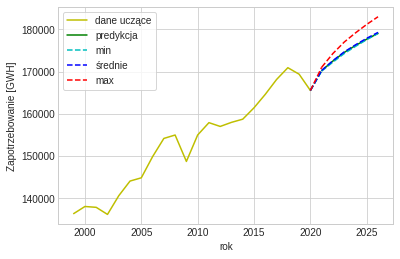

In [25]:
pred_pct = predict_changes(pred_valbas, solver.b)
y_pred = predict_values(dem_data.iloc[-1], pred_pct)

b_min, b_mean, b_max = solver.get_postopt_b()
x_min, x_mean, x_max = solver.get_postopt_x()

pct_min = predict_changes(pred_valbas, b_min)
pct_mean = predict_changes(pred_valbas, b_mean)
pct_max = predict_changes(pred_valbas, b_max)

y_pred_min = predict_values(dem_data.iloc[-1], pct_min)
y_pred_mean = predict_values(dem_data.iloc[-1], pct_mean)
y_pred_max = predict_values(dem_data.iloc[-1], pct_max)

reporter.plot_predictions_and_postopt( y_pred, y_pred_min, y_pred_mean, y_pred_max)